# Knowledge Graph Construction Pipeline

This notebook demonstrates the complete process of building a knowledge graph from raw text data. The pipeline includes:

1. Text collection through web scraping
2. Text preprocessing and cleaning
3. Named Entity Recognition (NER)
4. Relation Extraction (RE)
5. Knowledge Graph Construction
6. Visualization and querying

## Setup

First, let's import the necessary libraries and set up the environment.

In [1]:
# Import standard libraries
import os
import sys
import json
import logging
from pprint import pprint
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Configure logging
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(name)s - %(levelname)s - %(message)s'
)
logger = logging.getLogger(__name__)

In [2]:
# Add project root to path for importing local modules
# Adjust this path if needed
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
if project_root not in sys.path:
    sys.path.append(project_root)

# Import project modules
from src.data_collection.scraper import NewsArticleScraper
from src.preprocessing.cleaner import clean_text
from src.entity_recognition.ner import SpacyNERExtractor, CRFExtractor
from src.entity_recognition.comparison import NERComparison
from src.relation_extraction.extractor import SpacyRelationExtractor
from src.knowledge_graph.builder import KnowledgeGraphBuilder

# Create output directories
os.makedirs('output/data', exist_ok=True)
os.makedirs('output/models', exist_ok=True)
os.makedirs('output/visualization', exist_ok=True)

2025-03-09 12:32:04,230 - datasets - INFO - PyTorch version 2.6.0 available.
2025-03-09 12:32:04,246 - datasets - INFO - TensorFlow version 2.18.0 available.


## 1. Data Collection

Let's collect news articles from Reuters using our web scraper.

In [ ]:
# Initialize scraper
scraper = NewsArticleScraper(output_dir='output/data/raw')

# Scrape articles
# Note: This might take a while and might be rate-limited by the website
# For demonstration, we can scrape a smaller number of articles
# We can also use example data if scraping fails
try:
    article_files = scraper.scrape_reuters(num_articles=15, category='business')
    print(f"Scraped {len(article_files)} articles:")
    for file in article_files:
        print(f"- {os.path.basename(file)}")
except Exception as e:
    logger.error(f"Error scraping articles: {e}")
    # Use example data if scraping fails
    logger.info("Using example data instead")
    # Create a simple example article
    example_article = {
        "id": "example1",
        "title": "Apple announces new partnership with Microsoft",
        "url": "https://example.com/article1",
        "source": "example",
        "category": "business",
        "published_date": "2023-01-01",
        "scraped_date": "2023-01-02",
        "content": "Apple Inc. has announced a new partnership with Microsoft Corporation, according to CEO Tim Cook. \
The collaboration will focus on cloud computing services and AI integration. \
The partnership was revealed at a press conference in Cupertino, California yesterday. \
Microsoft CEO Satya Nadella expressed excitement about working with the iPhone maker. \
Apple was founded by Steve Jobs in 1976 and has become one of the world's most valuable companies."
    }
    
    # Save example article
    os.makedirs('output/data/raw', exist_ok=True)
    example_file = 'output/data/raw/example_article.json'
    with open(example_file, 'w', encoding='utf-8') as f:
        json.dump(example_article, f, ensure_ascii=False, indent=4)
    
    article_files = [example_file]

## 2. Text Preprocessing

Now let's preprocess the text from the articles we collected.
We retrieve the .json files and check for duplicates.

In [16]:
# Load articles from raw data directory with duplicate detection
import glob
import hashlib

def load_articles_from_directory(directory_path):
    """
    Load JSON articles from a directory with duplicate detection.
    
    Args:
        directory_path (str): Path to directory containing JSON files
        
    Returns:
        list: List of unique article dictionaries
    """
    # Get all JSON files in the directory
    json_files = glob.glob(f"{directory_path}/*.json")
    print(f"Found {len(json_files)} JSON files in {directory_path}")
    
    articles = []
    article_hashes = set()  # Store content hashes to detect duplicates
    
    for file in json_files:
        try:
            with open(file, 'r', encoding='utf-8') as f:
                article = json.load(f)
                
                # Skip if article doesn't have content
                if 'content' not in article or not article['content']:
                    print(f"Skipping {os.path.basename(file)}: No content")
                    continue
                
                # Create a hash of the article content to detect duplicates
                content_hash = hashlib.md5(article['content'].encode('utf-8')).hexdigest()
                
                if content_hash in article_hashes:
                    print(f"Skipping {os.path.basename(file)}: Duplicate content")
                    continue
                
                # Add hash to set and article to list
                article_hashes.add(content_hash)
                articles.append(article)
                print(f"Loaded {os.path.basename(file)}")
                
        except Exception as e:
            print(f"Error loading {os.path.basename(file)}: {e}")
    
    print(f"\nLoaded {len(articles)} unique articles successfully")
    return articles

# Path to raw data directory
raw_data_dir = './output/data/raw'

# Load unique articles
articles = load_articles_from_directory(raw_data_dir)

# Extract text content
article_texts = [article['content'] for article in articles]
article_titles = [article.get('title', 'Untitled') for article in articles]

# Show first article
if article_texts:
    print(f"Article Title: {article_titles[0] if article_titles[0] else 'No title'}")
    print(f"\nRaw Text:")
    print(article_texts[0][:500] + "..." if len(article_texts[0]) > 500 else article_texts[0])
else:
    print("No articles with content found")

Found 17 JSON files in ./output/data/raw
Loaded example_article.json
Loaded reuters_20250307_205801_.json
Loaded reuters_20250307_205849_.json
Loaded reuters_20250307_210517_.json
Loaded reuters_20250307_210553_.json
Loaded reuters_20250307_210638_.json
Loaded reuters_20250307_210718_.json
Loaded reuters_20250307_210755_.json
Loaded reuters_20250307_210831_.json
Skipping reuters_20250307_210912_.json: Duplicate content
Loaded reuters_20250307_211000_.json
Loaded reuters_20250307_211035_.json
Loaded reuters_20250307_211115_.json
Loaded reuters_20250307_211202_.json
Loaded reuters_20250307_211251_.json
Loaded reuters_20250307_211325_.json
Loaded reuters_20250307_211408_.json

Loaded 16 unique articles successfully
Article Title: Apple announces new partnership with Microsoft

Raw Text:
Apple Inc. has announced a new partnership with Microsoft Corporation, according to CEO Tim Cook. The collaboration will focus on cloud computing services and AI integration. The partnership was revealed a

In [17]:
# Preprocess text
cleaned_texts = []
for text in article_texts:
    # Clean the text but keep capitalization for NER
    cleaned = clean_text(
        text,
        lowercase=False,  # Keep case for NER
        remove_stops=False,  # Keep stop words for context
        lemmatize=False,  # Don't lemmatize to preserve entities
    )
    cleaned_texts.append(cleaned)

# Show first cleaned text
print(f"Cleaned Text:")
print(cleaned_texts[0][:500] + "..." if len(cleaned_texts[0]) > 500 else cleaned_texts[0])

2025-03-09 12:35:59,592 - src.preprocessing.cleaner - INFO - Cleaning text...
2025-03-09 12:35:59,592 - src.preprocessing.cleaner - INFO - Text cleaning completed
2025-03-09 12:35:59,592 - src.preprocessing.cleaner - INFO - Cleaning text...
2025-03-09 12:35:59,592 - src.preprocessing.cleaner - INFO - Text cleaning completed
2025-03-09 12:35:59,592 - src.preprocessing.cleaner - INFO - Cleaning text...
2025-03-09 12:35:59,592 - src.preprocessing.cleaner - INFO - Text cleaning completed
2025-03-09 12:35:59,592 - src.preprocessing.cleaner - INFO - Cleaning text...
2025-03-09 12:35:59,592 - src.preprocessing.cleaner - INFO - Text cleaning completed
2025-03-09 12:35:59,592 - src.preprocessing.cleaner - INFO - Cleaning text...
2025-03-09 12:35:59,592 - src.preprocessing.cleaner - INFO - Text cleaning completed
2025-03-09 12:35:59,592 - src.preprocessing.cleaner - INFO - Cleaning text...
2025-03-09 12:35:59,592 - src.preprocessing.cleaner - INFO - Text cleaning completed
2025-03-09 12:35:59,59

Cleaned Text:
Apple Inc has announced a new partnership with Microsoft Corporation according to CEO Tim Cook The collaboration will focus on cloud computing services and AI integration The partnership was revealed at a press conference in Cupertino California yesterday Microsoft CEO Satya Nadella expressed excitement about working with the iPhone maker Apple was founded by Steve Jobs in 1976 and has become one of the worlds most valuable companies


## 3. Named Entity Recognition (NER)

Let's extract named entities from the preprocessed text using spaCy.

In [18]:
# Initialize NER extractors
spacy_extractor = SpacyNERExtractor()

# Extract entities
all_entities = []
for i, text in enumerate(cleaned_texts):
    entities = spacy_extractor.extract_entities(text)
    all_entities.append(entities)
    
    print(f"\nEntities from article {i+1}: {article_titles[i]}")
    for entity, entity_type in entities:
        print(f"- {entity} ({entity_type})")

2025-03-09 12:36:03,258 - src.entity_recognition.ner - INFO - Loaded spaCy model: en_core_web_sm



Entities from article 1: Apple announces new partnership with Microsoft
- Apple Inc (ORG)
- Microsoft Corporation (ORG)
- Tim Cook (PERSON)
- AI (GPE)
- Cupertino (GPE)
- California (GPE)
- yesterday (DATE)
- Microsoft (ORG)
- Satya Nadella (PERSON)
- iPhone (ORG)
- Apple (ORG)
- Steve Jobs (PERSON)
- 1976 (DATE)

Entities from article 2: 
- March 7 (DATE)
- Reuters - Wall Streets (ORG)
- Friday (DATE)
- Fed (ORG)
- Jerome Powell (PERSON)
- Trump (ORG)
- Powell (PERSON)
- the Federal Reserve (ORG)
- Fed (ORG)
- Oliver Pursche (PERSON)
- Wealthspire Advisors At (ORG)
- 0100 pm ET (TIME)
- 7145 (CARDINAL)
- 017 to 4250763 (CARDINAL)
- 500 (CARDINAL)
- 2191 (CARDINAL)
- 038 (CARDINAL)
- 10492 (CARDINAL)
- 058 (CARDINAL)
- 18 (CARDINAL)
- Wells Fargo (ORG)
- Goldman Sachs (ORG)
- 19 (CARDINAL)
- Meta METAO (PERSON)
- Amazoncom (ORG)
- more than 3 (CARDINAL)
- Labor Department (ORG)
- February (DATE)
- the previous month (DATE)
- 41 (CARDINAL)
- first (ORDINAL)
- this year to June (DATE)
-

### 3.1 NER Model Comparison (CRF vs. spaCy)

In a full implementation, we would train a CRF model on the CoNLL-2003 dataset and compare it with spaCy's model. For this demonstration, we'll just use the spaCy model.

Note: In a complete implementation, we would train a CRF model 
on the CoNLL-2003 dataset and compare it with spaCy's model.
For simplicity in this demonstration, we're only using spaCy's model.


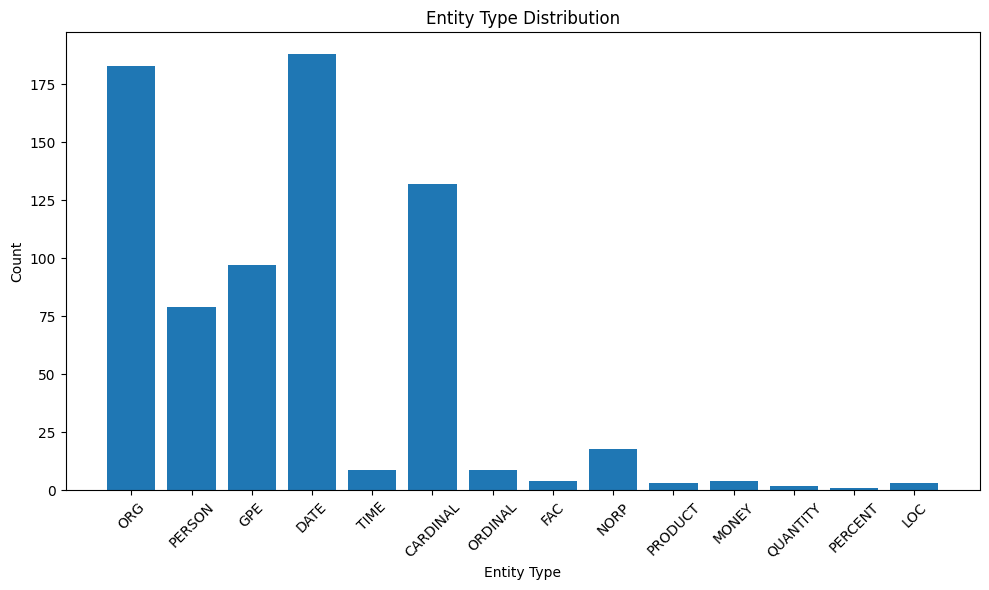

In [19]:
# For demonstration, let's simulate a CRF model comparison
print("Note: In a complete implementation, we would train a CRF model ")
print("on the CoNLL-2003 dataset and compare it with spaCy's model.")
print("For simplicity in this demonstration, we're only using spaCy's model.")

# Display entity distribution
entity_types = {}
for article_entities in all_entities:
    for entity, entity_type in article_entities:
        if entity_type not in entity_types:
            entity_types[entity_type] = 0
        entity_types[entity_type] += 1

# Plot entity type distribution
plt.figure(figsize=(10, 6))
plt.bar(entity_types.keys(), entity_types.values())
plt.title('Entity Type Distribution')
plt.xlabel('Entity Type')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## 4. Relation Extraction

Now let's extract relations between the entities we identified.

In [20]:
# Initialize relation extractor
relation_extractor = SpacyRelationExtractor()

# Extract relations
all_relations = []
for i, text in enumerate(cleaned_texts):
    relations = relation_extractor.extract_relations(text)
    
    # Filter out self-relations
    filtered_relations = []
    for subject, predicate, obj in relations:
        # Skip if subject and object are the same entity
        if subject[0] != obj[0]:
            filtered_relations.append((subject, predicate, obj))
    
    all_relations.append(filtered_relations)
    
    print(f"\nRelations from article {i+1}: {article_titles[i]}")
    for subject, predicate, obj in filtered_relations:
        print(f"- {subject[0]} ({subject[1]}) --[{predicate}]--> {obj[0]} ({obj[1]})")

2025-03-09 12:36:09,711 - src.relation_extraction.extractor - INFO - Loaded spaCy model: en_core_web_sm



Relations from article 1: Apple announces new partnership with Microsoft
- Apple (ORG) --[found in]--> 1976 (DATE)
- Cupertino (GPE) --[related_to]--> California (GPE)
- Apple (ORG) --[found_in]--> 1976 (DATE)

Relations from article 2: 

Relations from article 3: 
- The Labor Departments (ORG) --[watch on]--> Friday (DATE)
- The Labor Departments (ORG) --[watch_on]--> Friday (DATE)

Relations from article 4: 
- Adriana Kugler (PERSON) --[say on]--> Friday (DATE)
- Adriana Kugler (PERSON) --[say_on]--> Friday (DATE)

Relations from article 5: 
- Nasdaq (ORG) --[confirm At]--> 255 pm (TIME)
- Richmond (GPE) --[related_to]--> Virginia (GPE)
- Thursday (DATE) --[related_to]--> Trump (PERSON)
- Nasdaq (ORG) --[confirm_At]--> 255 pm (TIME)

Relations from article 6: 
- Reuters - Morgan Stanley (ORG) --[lower on]--> Friday (DATE)
- Goldman Sachs (ORG) --[downgrade to]--> 17 (CARDINAL)
- Reuters - Morgan Stanley (ORG) --[lower_on]--> Friday (DATE)
- Goldman Sachs (ORG) --[downgrade_to]--> 17

## 5. Knowledge Graph Construction

Now let's build a knowledge graph from the extracted entities and relations.

In [21]:
# Initialize knowledge graph builder
kg_builder = KnowledgeGraphBuilder(namespace="http://example.org/graphify/")

# Collect all entities and relations
all_kg_entities = set()
all_kg_relations = []

for entities in all_entities:
    for entity in entities:
        all_kg_entities.add(entity)

for relations in all_relations:
    all_kg_relations.extend(relations)

# Add to knowledge graph
kg_builder.add_entities_and_relations(list(all_kg_entities), all_kg_relations)

# Save knowledge graph to file
kg_file = "output/data/knowledge_graph.ttl"
kg_builder.save_to_file(kg_file, format="turtle")
print(f"\nKnowledge graph saved to {kg_file}")

# Display stats
print(f"\nKnowledge Graph Statistics:")
print(f"- Entities: {len(all_kg_entities)}")
print(f"- Relations: {len(all_kg_relations)}")
print(f"- Triples: {len(kg_builder.get_triples())}")

2025-03-09 12:36:13,321 - src.knowledge_graph.builder - INFO - Initialized knowledge graph with namespace: http://example.org/graphify/
2025-03-09 12:36:13,339 - src.knowledge_graph.builder - INFO - Added 438 entities and 35 relations
2025-03-09 12:36:13,371 - src.knowledge_graph.builder - INFO - Saved knowledge graph to output/data/knowledge_graph.ttl in turtle format



Knowledge graph saved to output/data/knowledge_graph.ttl

Knowledge Graph Statistics:
- Entities: 438
- Relations: 35
- Triples: 927


## 6. Visualization

Let's create visualizations of our knowledge graph.

2025-03-09 12:36:16,248 - src.knowledge_graph.builder - INFO - Initialized knowledge graph with namespace: http://example.org/graphify/
2025-03-09 12:36:16,251 - src.knowledge_graph.builder - INFO - Added 37 entities and 35 relations
2025-03-09 12:36:16,888 - src.knowledge_graph.builder - INFO - Saved plot to output/visualization/knowledge_graph_plot.png
2025-03-09 12:36:16,902 - src.knowledge_graph.builder - INFO - Saved visualization to output/visualization/knowledge_graph_interactive.html


Static plot saved to output/visualization/knowledge_graph_plot.png
Interactive visualization saved to output/visualization/knowledge_graph_interactive.html


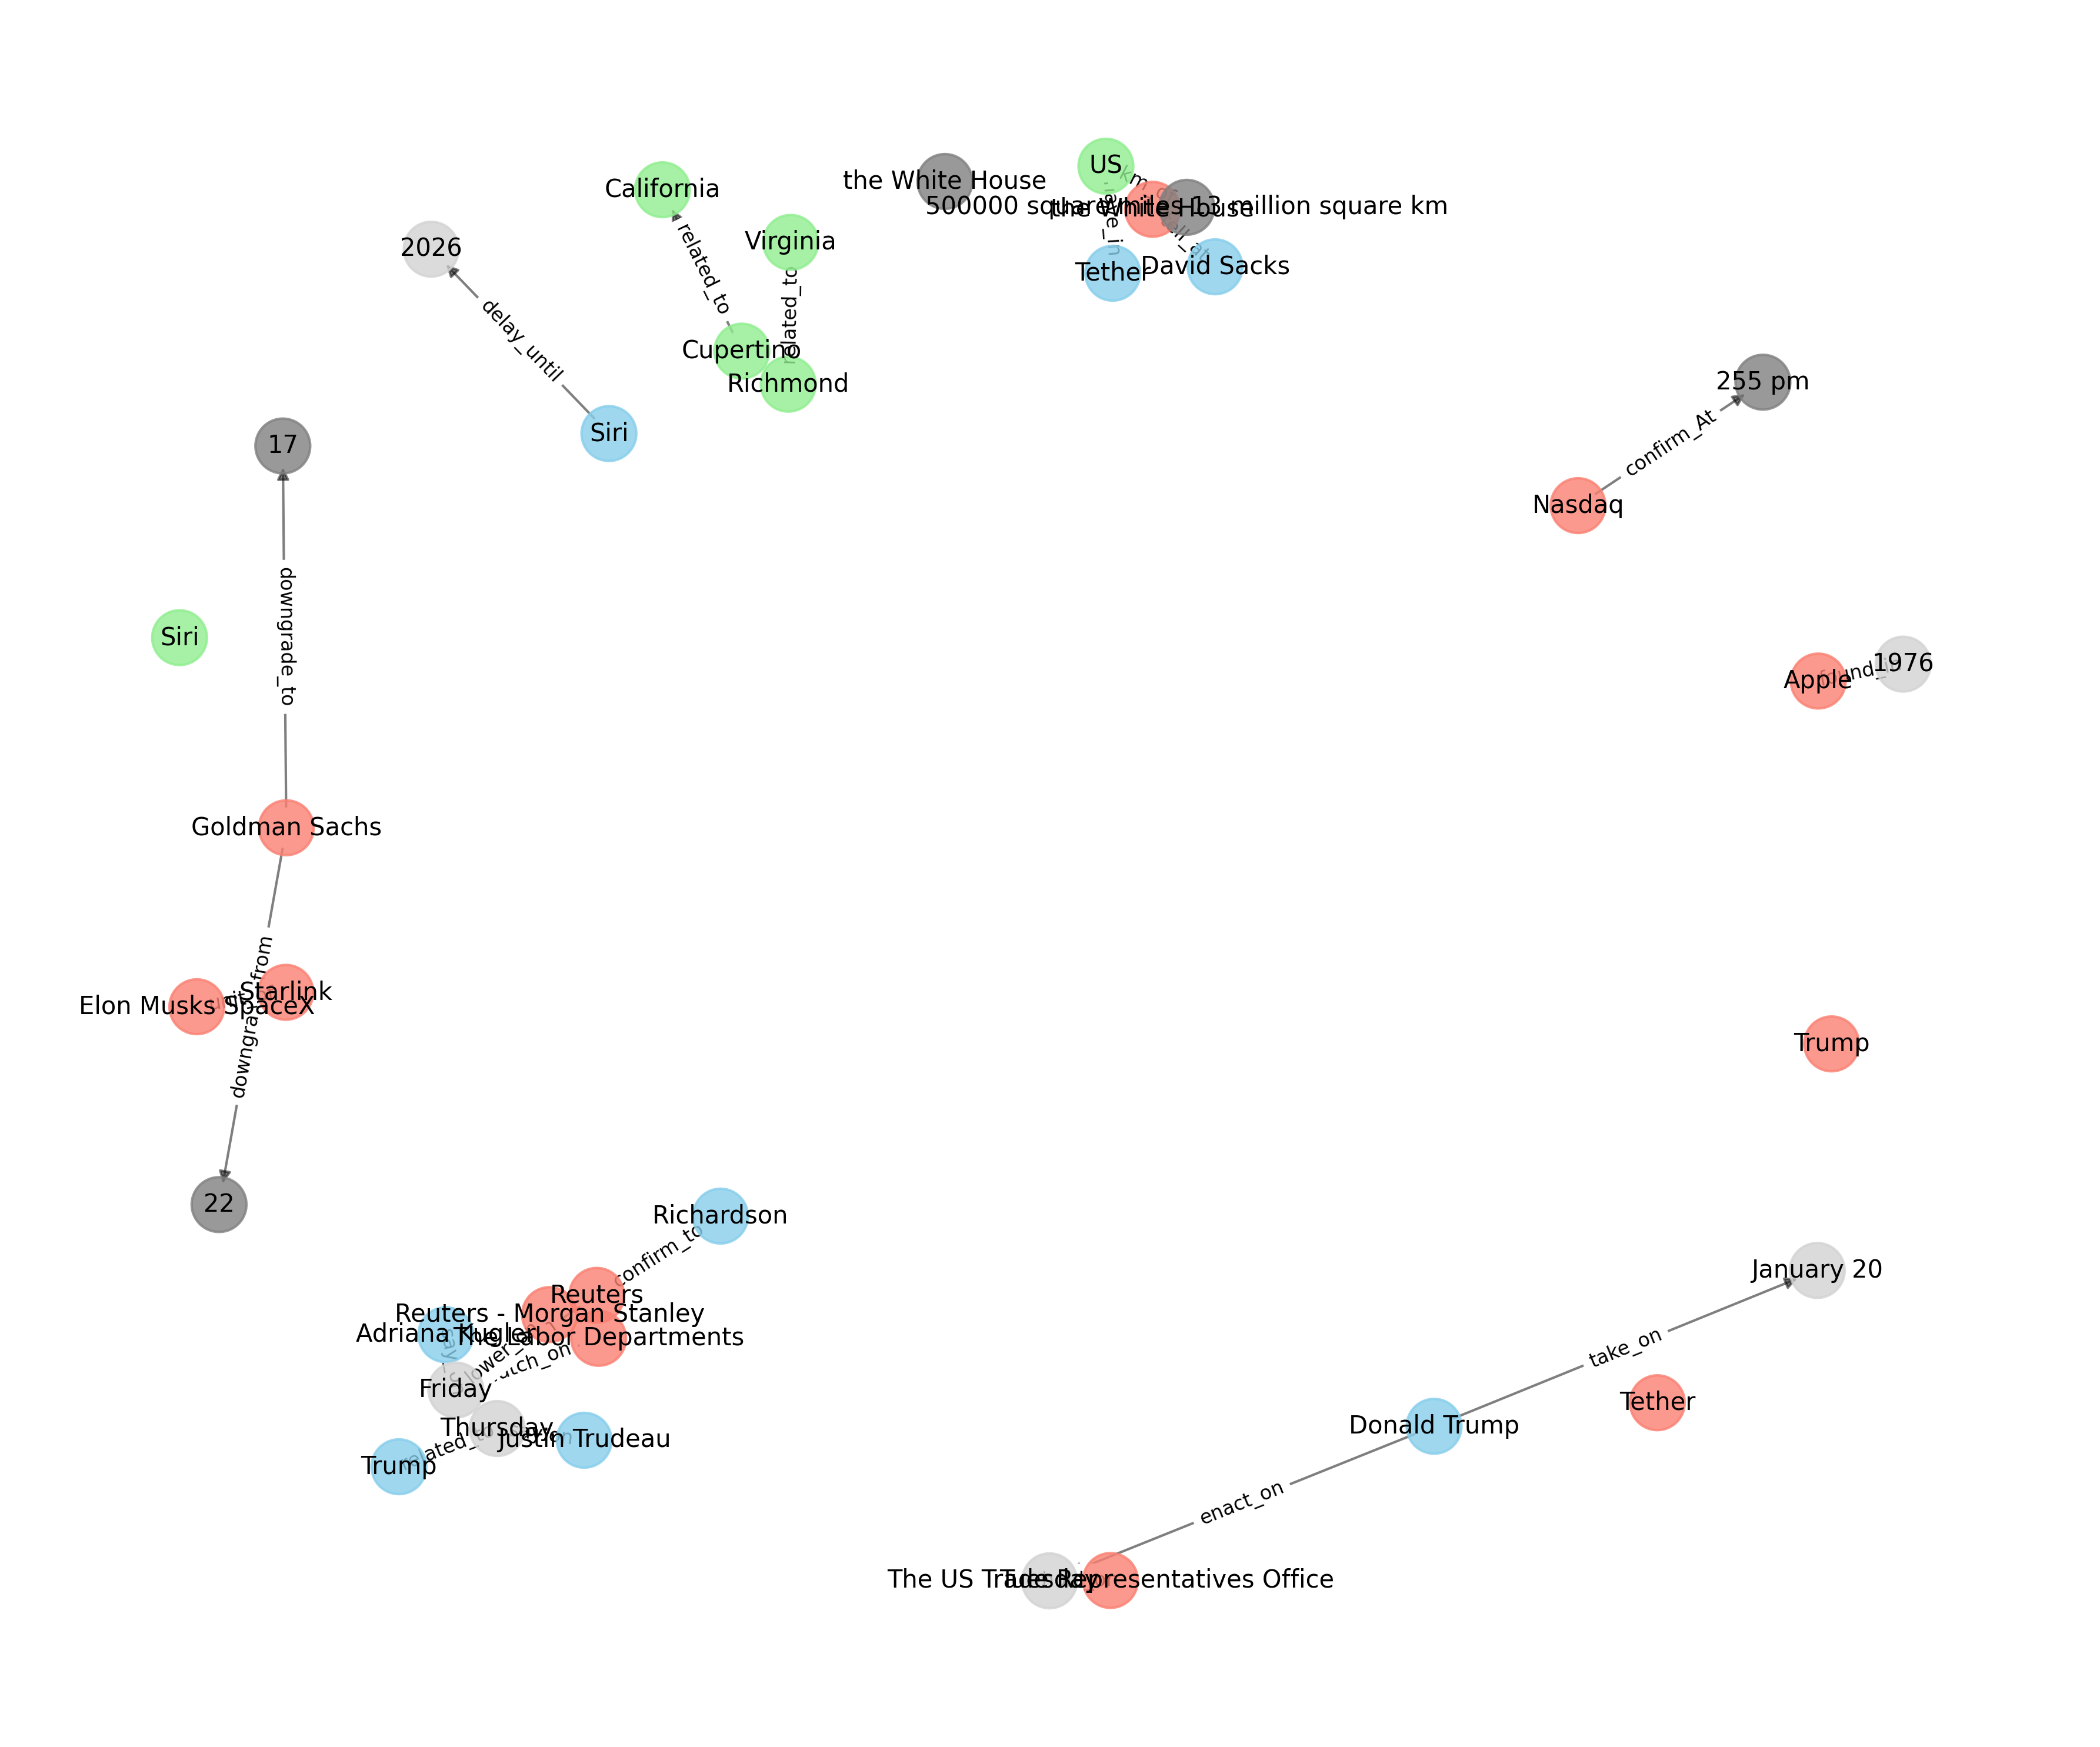

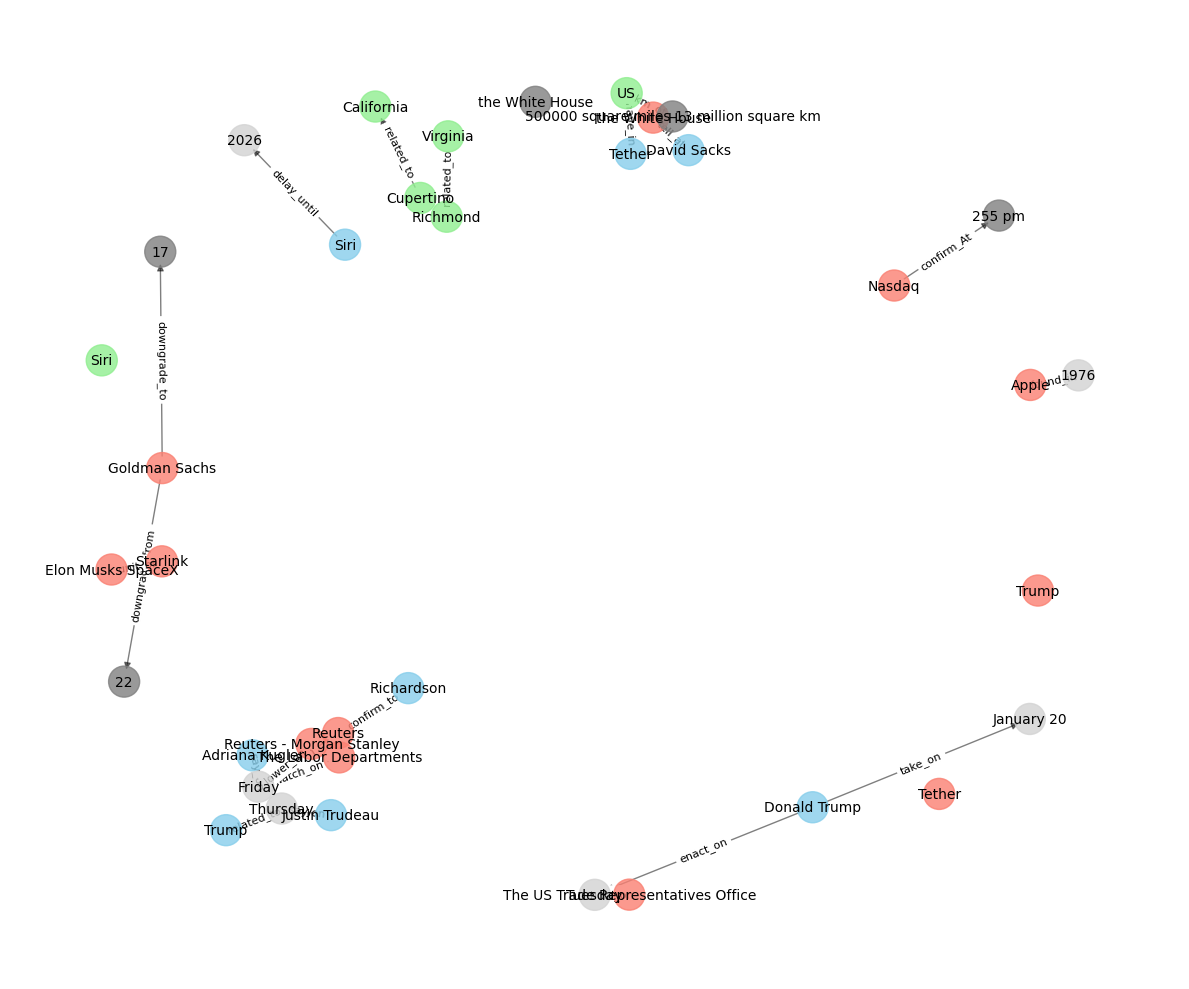

In [22]:
# Create visualizations
# Before visualizing, filter out nodes without relations

# Get all entities that participate in relationships
connected_entities = set()
for relations in all_relations:
    for subject, predicate, obj in relations:
        connected_entities.add(subject[0])  # Add subject text
        connected_entities.add(obj[0])      # Add object text

# Filter the entities to only include those with relations
connected_kg_entities = [entity for entity in all_kg_entities if entity[0] in connected_entities]

# Now use the filtered entities for visualization
kg_builder = KnowledgeGraphBuilder(namespace="http://example.org/graphify/")
kg_builder.add_entities_and_relations(connected_kg_entities, all_kg_relations)

# Static plot
plot_file = "output/visualization/knowledge_graph_plot.png"
kg_builder.plot_graph(plot_file)
print(f"Static plot saved to {plot_file}")

# Interactive visualization
vis_file = "output/visualization/knowledge_graph_interactive.html"
kg_builder.visualize(vis_file)
print(f"Interactive visualization saved to {vis_file}")

# Display the static plot in the notebook
from IPython.display import Image
Image(filename=plot_file)

## 7. Querying the Knowledge Graph

Let's run some SPARQL queries on our knowledge graph.

In [12]:
# Example query 1: Find all organizations and their locations
query1 = """
PREFIX ns: <http://example.org/graphify/>
PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>

SELECT ?org ?loc
WHERE {
    ?org_uri rdf:type ns:ORG .
    ?loc_uri rdf:type ns:GPE .
    ?org_uri ?pred ?loc_uri .
    ?org_uri <http://www.w3.org/2000/01/rdf-schema#label> ?org .
    ?loc_uri <http://www.w3.org/2000/01/rdf-schema#label> ?loc .
}
"""

results1 = kg_builder.query_sparql(query1)
print("Organizations and their locations:")
for row in results1:
    print(f"- {row[0]} is located in {row[1]}")

Organizations and their locations:


In [13]:
# Example query 2: Find all people and their organizations
query2 = """
PREFIX ns: <http://example.org/graphify/>
PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>

SELECT ?person ?org
WHERE {
    ?person_uri rdf:type ns:PERSON .
    ?org_uri rdf:type ns:ORG .
    ?pred_uri ?person_uri ?org_uri .
    ?person_uri <http://www.w3.org/2000/01/rdf-schema#label> ?person .
    ?org_uri <http://www.w3.org/2000/01/rdf-schema#label> ?org .
}
"""

results2 = kg_builder.query_sparql(query2)
print("People and their organizations:")
for row in results2:
    print(f"- {row[0]} is associated with {row[1]}")

People and their organizations:


## 8. Exporting Results for Further Analysis

Let's export the entities and relations to CSV files for further analysis.

In [14]:
# Export entities to CSV
entity_data = []
for entity_text, entity_type in all_kg_entities:
    entity_data.append({'entity': entity_text, 'type': entity_type})

entity_df = pd.DataFrame(entity_data)
entity_csv = "output/data/entities.csv"
entity_df.to_csv(entity_csv, index=False)
print(f"Entities exported to {entity_csv}")

# Export relations to CSV
relation_data = []
for subject, predicate, obj in all_kg_relations:
    relation_data.append({
        'subject': subject[0],
        'subject_type': subject[1],
        'predicate': predicate,
        'object': obj[0],
        'object_type': obj[1]
    })

relation_df = pd.DataFrame(relation_data)
relation_csv = "output/data/relations.csv"
relation_df.to_csv(relation_csv, index=False)
print(f"Relations exported to {relation_csv}")

Entities exported to output/data/entities.csv
Relations exported to output/data/relations.csv


## 9. Conclusion

In this notebook, we've demonstrated the complete pipeline for building a knowledge graph from raw text data:

1. We collected articles using a web scraper
2. We preprocessed and cleaned the text
3. We extracted named entities using spaCy
4. We extracted relations between entities
5. We built a knowledge graph from the entities and relations
6. We visualized and queried the knowledge graph

This pipeline can be extended by:
- Training a CRF model for NER and comparing it with spaCy's performance
- Implementing more sophisticated relation extraction methods
- Adding more data sources
- Expanding the knowledge graph with additional entity types and relations
- Developing applications that use the knowledge graph for search, recommendation, or other tasks